In [74]:
import torch, torchvision
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

In [128]:
# Taken from https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#instance-segmentation-models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)

    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    fig.subplots_adjust(wspace=1, hspace=1)

## Dataset

In [76]:
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as F


class Dataset(torchvision.datasets.VisionDataset):
    def __init__(self, img_dir: str = ".\\dataset\\images\\", mask_dir: str = ".\\dataset\\masks\\"):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_filename = self.images[idx]
        image = torchvision.io.read_image(self.img_dir + image_filename)
        
        mask_filename = self.masks[idx]
        mask = torchvision.io.read_image(self.mask_dir + mask_filename)

        # Resize
        image = F.resize(
            image, (520, 520),
            interpolation=transforms.InterpolationMode.BILINEAR
        ).float()

        image /= 255.0

        image = F.normalize(
            image,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        mask = F.resize(
            mask, (520, 520),
            interpolation=transforms.InterpolationMode.BILINEAR
        )

        mask = mask[0].squeeze(0)
        mask[mask != 0] = 1 if "easyportrait" in image_filename else 2
        
        return image, mask

C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


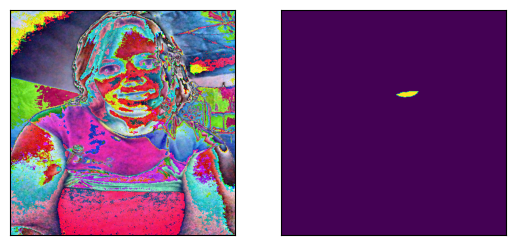

In [77]:
dataset = Dataset()
show(list(dataset[2]))

In [78]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

## Model

In [1]:
from torchvision.models.segmentation.lraspp import LRASPPHead

class Model(torch.nn.Module):
    def __init__(self, freeze_backbone: bool = True):
        super().__init__()
        
        # Layers
        self.mobile = torchvision.models.segmentation.lraspp_mobilenet_v3_large(weights=torchvision.models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT)
        self.mobile.classifier = LRASPPHead(low_channels = 40, high_channels = 960, num_classes = 3, inter_channels = 128)
        self.softmax = torch.nn.Softmax(dim=1)

        # Freeze backbone
        if freeze_backbone:
            # Freeze all backbone
            for param in self.mobile.backbone.parameters():
                param.requires_grad = False
                
    def unfreeze_backbone(self):
        for param in self.mobile.backbone.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.softmax(self.mobile(x)['out'])

class Pipeline(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        image, mask = batch
        
        out = self.forward(image.float())
        loss = self.criterion(out, mask.long())
        
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(out, 1).unsqueeze(1),
                                               mask.long().unsqueeze(1),
                                               mode='multiclass',
                                               num_classes=3)
        
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        self.log(f"train_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"train_loss", loss) 
        
        return {"loss": loss, "iou": iou}
    
    def configure_optimizers(self):
        return self.optimizer

NameError: name 'torch' is not defined

In [82]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.0, 1.0]))

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='.\\checkpoints',
                                                   filename='29_1_jan_24', 
                                                   verbose=True, 
                                                   monitor='train_IoU', 
                                                   mode='max')

#### First round

In [83]:
NUM_EPOCHS = 10
NUM_GPUS = 1

ligtning_model = Pipeline(model, optimizer, criterion)
trainer = pl.Trainer(callbacks=checkpoint_callback, accelerator='gpu', devices=NUM_GPUS, max_epochs=NUM_EPOCHS)
trainer.fit(ligtning_model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Model            | 3.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
246 K     Trainable params
3.0 M     Non-trainable params
3.2 M     Total params
12.874    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 34/34 [00:09<00:00,  3.66it/s, v_num=33, train_IoU_step=0.263, train_IoU_epoch=0.228]

Epoch 0, global step 34: 'train_IoU' reached 0.22802 (best 0.22802), saving model to '.\\checkpoints\\29_1_jan_24.ckpt' as top 1


Epoch 1: 100%|██████████| 34/34 [00:09<00:00,  3.58it/s, v_num=33, train_IoU_step=0.312, train_IoU_epoch=0.304]

Epoch 1, global step 68: 'train_IoU' reached 0.30371 (best 0.30371), saving model to '.\\checkpoints\\29_1_jan_24.ckpt' as top 1


Epoch 2: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s, v_num=33, train_IoU_step=0.344, train_IoU_epoch=0.343]

Epoch 2, global step 102: 'train_IoU' reached 0.34281 (best 0.34281), saving model to '.\\checkpoints\\29_1_jan_24.ckpt' as top 1


Epoch 3: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s, v_num=33, train_IoU_step=0.366, train_IoU_epoch=0.375]

Epoch 3, global step 136: 'train_IoU' reached 0.37526 (best 0.37526), saving model to '.\\checkpoints\\29_1_jan_24.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 34/34 [00:09<00:00,  3.62it/s, v_num=33, train_IoU_step=0.366, train_IoU_epoch=0.375]


#### 2nd round

In [84]:
NUM_EPOCHS = 15
NUM_GPUS = 1

# Unfreeze backbone
ligtning_model.model.unfreeze_backbone()

trainer = pl.Trainer(callbacks=checkpoint_callback, accelerator='gpu', devices=NUM_GPUS, max_epochs=NUM_EPOCHS)
trainer.fit(ligtning_model, dataloader)

# Train
trainer.fit(ligtning_model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Model            | 3.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.874    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 34/34 [00:13<00:00,  2.47it/s, v_num=34, train_IoU_step=0.503, train_IoU_epoch=0.441]

Epoch 0, global step 34: 'train_IoU' reached 0.44067 (best 0.44067), saving model to '.\\checkpoints\\29_1_jan_24.ckpt' as top 1


Epoch 1: 100%|██████████| 34/34 [00:13<00:00,  2.57it/s, v_num=34, train_IoU_step=0.766, train_IoU_epoch=0.570]

Epoch 1, global step 68: 'train_IoU' reached 0.56985 (best 0.56985), saving model to '.\\checkpoints\\29_1_jan_24.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 34/34 [00:13<00:00,  2.52it/s, v_num=34, train_IoU_step=0.766, train_IoU_epoch=0.570]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Model            | 3.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.874    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=2` reached.


## Test

In [86]:
model.eval().to("cuda")

Model(
  (mobile): LRASPP(
    (backbone): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivati

In [92]:
model_pembanding = torch.load(".\\models\\lips_trained_21_2_nov_23.pth")
model_pembanding.eval().to("cuda")

Model(
  (mobile): LRASPP(
    (backbone): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivati

C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


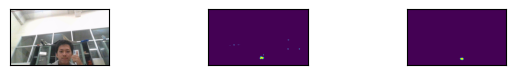

In [129]:
raw_img = torchvision.io.read_image(".\\dataset\\WIN_20230918_02_11_03_Pro.jpg")

img = F.resize(
    raw_img, 540,
    interpolation=transforms.InterpolationMode.BILINEAR
).float()

img /= 255.0

img = F.normalize(
    img,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

result_6_epoch = model(img.unsqueeze(0).to("cuda"))
result_15_epoch = model_pembanding(img.unsqueeze(0).to("cuda"))
show([raw_img, (result_6_epoch.argmax(1) == 1).type(torch.uint8), (result_15_epoch.argmax(1) == 1).type(torch.uint8)])

In [90]:
from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(result.argmax(1) == 2)
boxes = boxes * (raw_img.shape[1] / result.shape[2])

In [68]:
x1, y1, x2, y2 = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
x, y = (x2 + x1) / 2, (y2 + y1) / 2

In [69]:
x, y

(tensor(464., device='cuda:0'), tensor(489., device='cuda:0'))

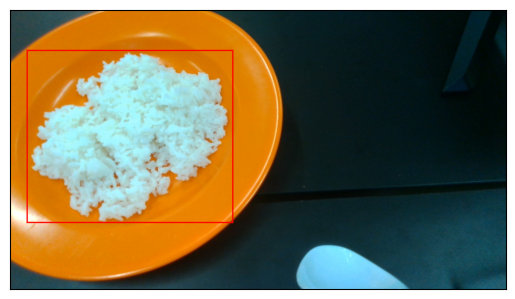

In [72]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks, draw_keypoints

drawn_boxes = draw_bounding_boxes(raw_img, boxes, colors="red", width=5)
show(drawn_boxes)

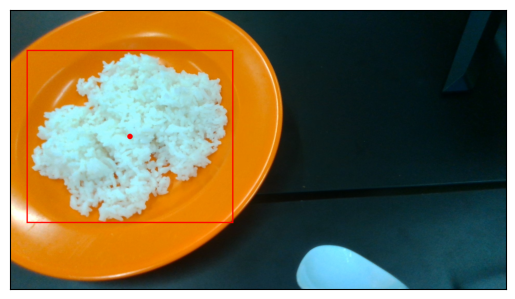

In [73]:
pointed = draw_keypoints(drawn_boxes, torch.Tensor([[[x, y, 1]]]), colors="red", radius=10)
show(pointed)

C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


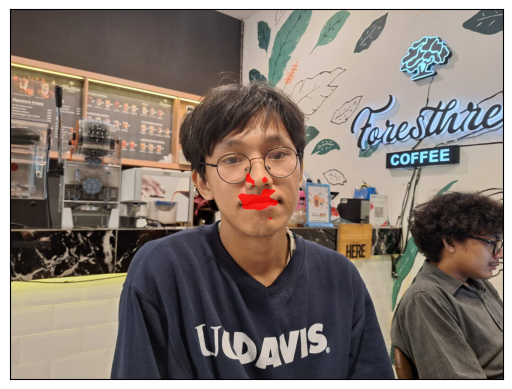

In [91]:
resized_result = F.resize(
    result, 1200,
    interpolation=transforms.InterpolationMode.BILINEAR
).float()

drawn_masks = draw_segmentation_masks(raw_img, resized_result.argmax(1) == 1, colors="red")
show(drawn_masks)

In [ ]:
torch.save(model, '.\\models\\lips_trained_21_2_nov_23.pth')